In [2]:
from lib.trajectories import Trajectory, p_s_from_rollouts, p_sa_from_rollouts, sr_from_rollouts, average_reward_from_rollouts, sa_sr_from_rollouts
from lib.aggregation import get_aggregator
from plotting import plot_heatmap
import lib.aggregation as aggregation
import pickle
import numpy as np
import os

def read_pickle(save_name):
    """
    Thread-safe pickle read.
    Safe even if other threads are simultaneously calling dump_pickle()
    on the same file.
    """
    with open(save_name, "rb") as f:
        return pickle.load(f)
    
EXP_DIR="out/pendulum1"
params = read_pickle(os.path.join(EXP_DIR, "params.pkl"))


l1_random = read_pickle(os.path.join(EXP_DIR, "random_l1_covs.pkl"))
l1_eig = read_pickle(os.path.join(EXP_DIR, "eigenoptions_l1_covs.pkl"))
# l1_cov = read_pickle(os.path.join(EXP_DIR, "codex_l1_covs.pkl"))
l1_cov = l1_eig
l1_maxent = read_pickle(os.path.join(EXP_DIR, "maxent_l1_covs.pkl"))


stats_maxent = read_pickle(os.path.join(EXP_DIR, "maxent_stats.pkl"))
stats_random = read_pickle(os.path.join(EXP_DIR, "random_stats.pkl"))
stats_eig = read_pickle(os.path.join(EXP_DIR, "eigenoptions_stats.pkl"))
# stats_cov = read_pickle(os.path.join(EXP_DIR, "codex_stats.pkl"))
stats_cov = stats_eig
base_args = params["base_args"]

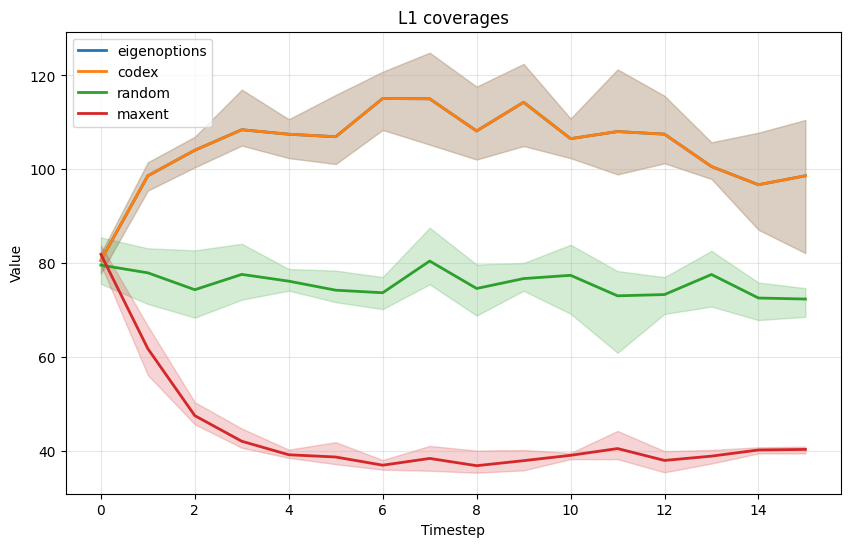

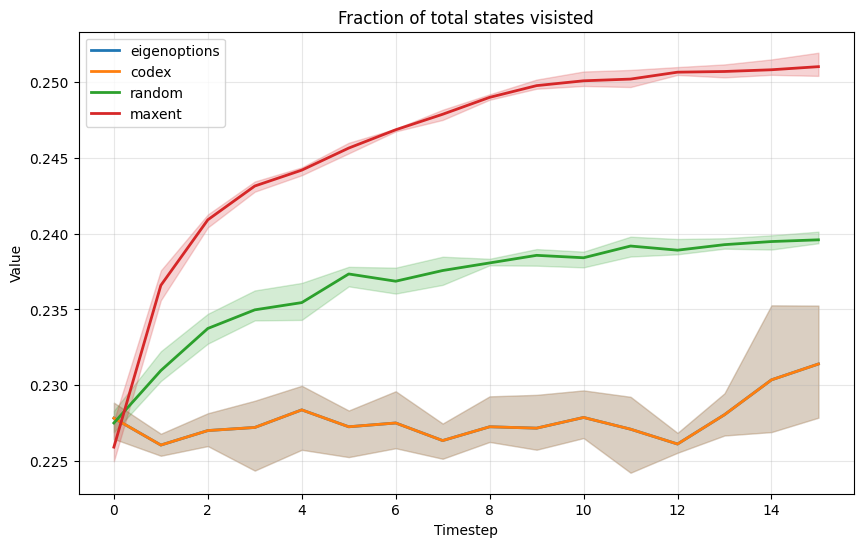

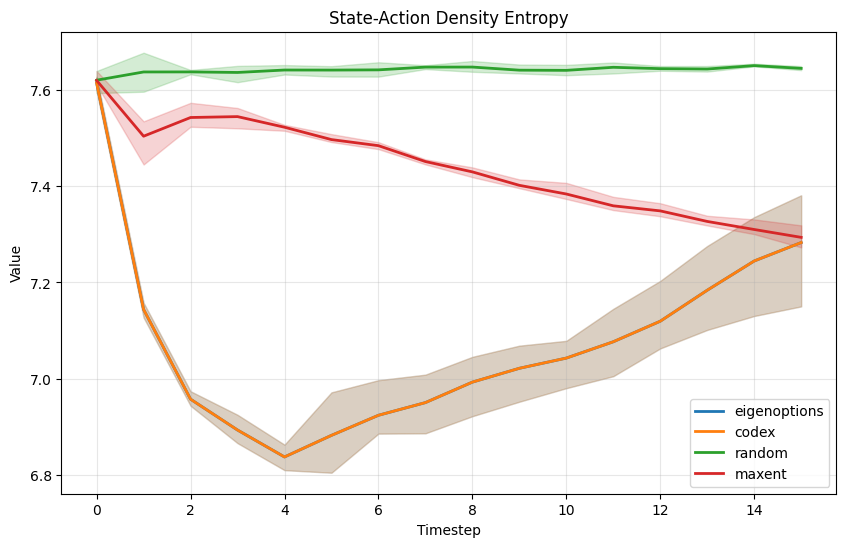

In [11]:

import matplotlib.pyplot as plt
import numpy as np

def plot_competing(*datasets, labels=None, colors=None, title="Comparison of Series"):
    """
    Plots an arbitrary number of datasets with mean lines and 95% confidence intervals.
    
    Args:
        *datasets: Variable number of 2D lists/arrays (shape: [samples, timesteps]).
        labels (list): List of strings for the legend.
        colors (list): List of color codes. If None, uses default cycle.
        title (str): Plot title.
    """
    plt.figure(figsize=(10, 6))
    
    # Create default labels if none provided
    if labels is None:
        labels = [f"Series {i+1}" for i in range(len(datasets))]
        
    # Create a distinct color for each dataset if not provided
    if colors is None:
        # Get the default color cycle from matplotlib
        prop_cycle = plt.rcParams['axes.prop_cycle']
        default_colors = prop_cycle.by_key()['color']
        # Cycle through defaults if we have more datasets than colors
        colors = [default_colors[i % len(default_colors)] for i in range(len(datasets))]

    for i, data in enumerate(datasets):
        # Convert to numpy array for easier math (axis operations)
        data = np.array(data)
        
        # Calculate Mean and Standard Error
        mean = np.mean(data, axis=0)
        n = data.shape[0]
        
        # Calculate 95% Confidence Interval (1.96 * Standard Error)
        lower = np.percentile(data, 2.5, axis=0)
        upper = np.percentile(data, 97.5, axis=0)


        
        # Define X-axis (Timesteps)
        timesteps = np.arange(len(mean))
        
        # Plot the Mean Line
        plt.plot(timesteps, mean, label=labels[i], color=colors[i], linewidth=2)
        
        # Plot the Shaded Region (Upper and Lower bounds)
        plt.fill_between(
            timesteps, 
            lower, 
            upper, 
            color=colors[i], 
            alpha=0.2  # Low alpha for transparency
        )
        # for j in range(n):
        #     plt.plot(timesteps, data[j], color=colors[i], linewidth=1, alpha=0.2)

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


plot_competing(l1_eig, l1_cov, l1_random, l1_maxent, labels=["eigenoptions", "codex", "random", "maxent"], title="L1 coverages" )

stats = [stats_eig, stats_cov, stats_random, stats_maxent]

usv_eig, usv_cov, usv_random, usv_maxent = (i["visited_sa_ratio"] for i in stats)


plot_competing(usv_eig, usv_cov, usv_random, usv_maxent, labels=["eigenoptions", "codex", "random", "maxent"], title="Fraction of total states visisted")

usv_eig, usv_cov, usv_random, usv_maxent = (i["p_sa_entropy"] for i in stats)
plot_competing(usv_eig, usv_cov, usv_random, usv_maxent, labels=["eigenoptions", "codex", "random", "maxent"], title="State-Action Density Entropy")

Pendulum-v1


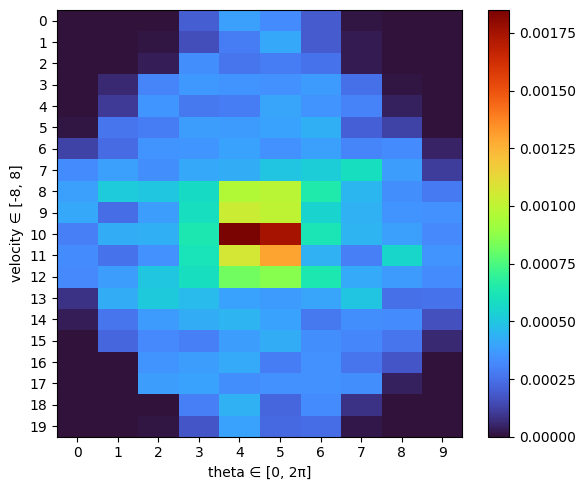

Pendulum-v1


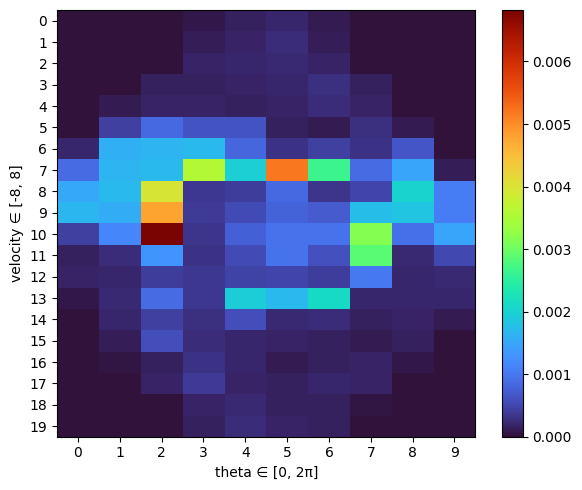

Pendulum-v1


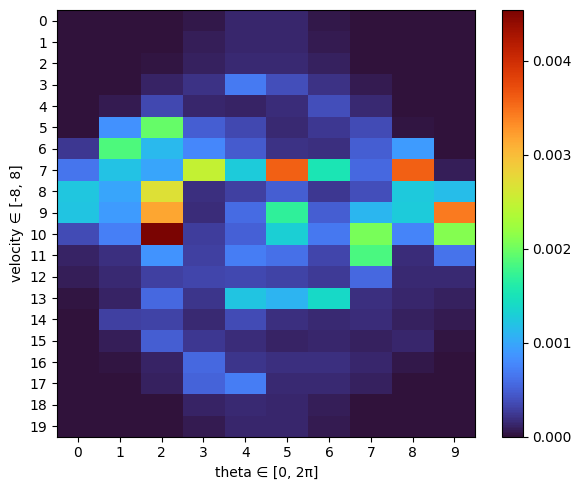

Pendulum-v1


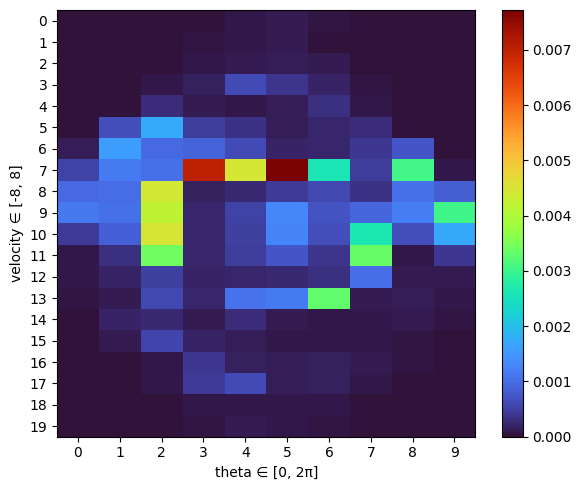

Pendulum-v1


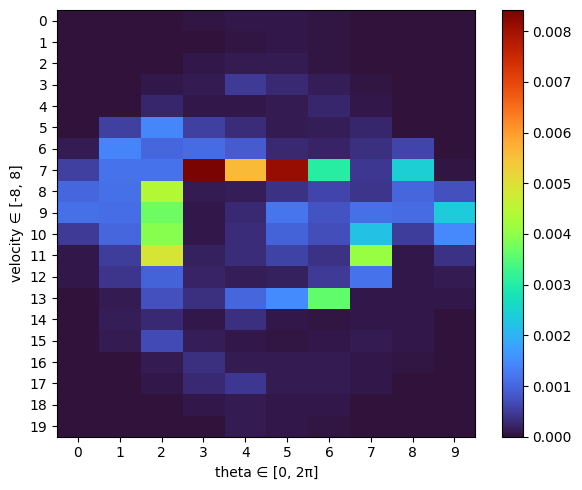

Pendulum-v1


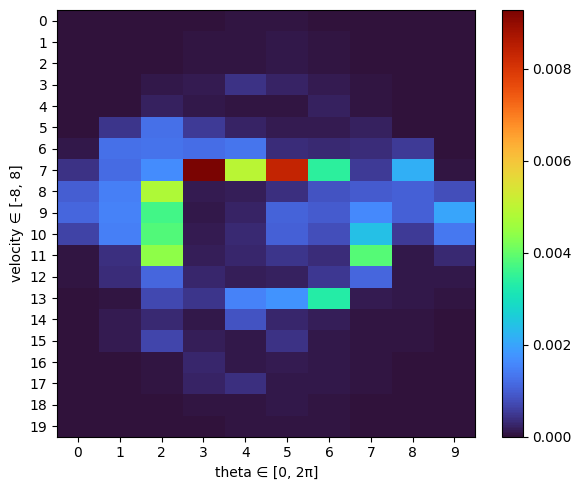

Pendulum-v1


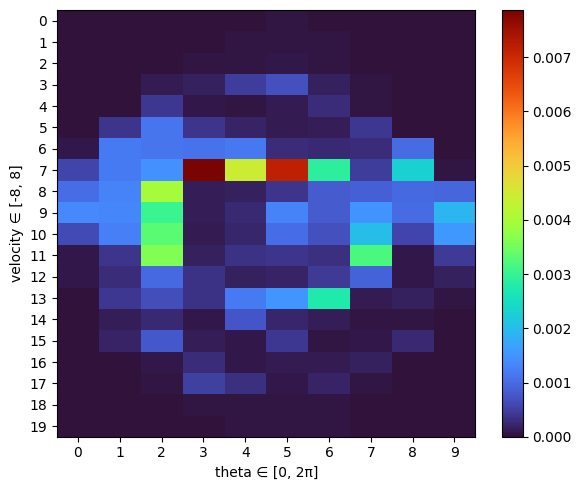

Pendulum-v1


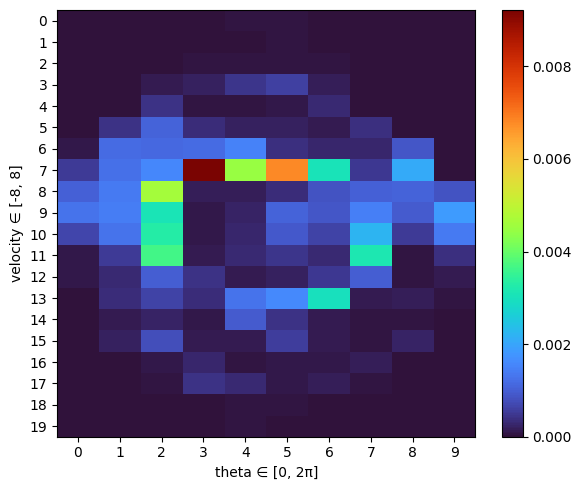

Pendulum-v1


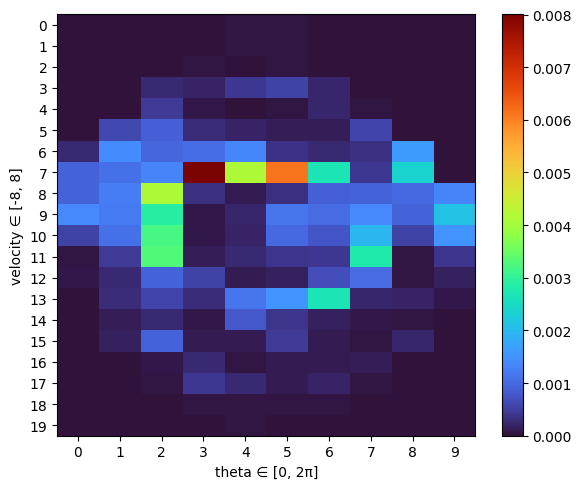

Pendulum-v1


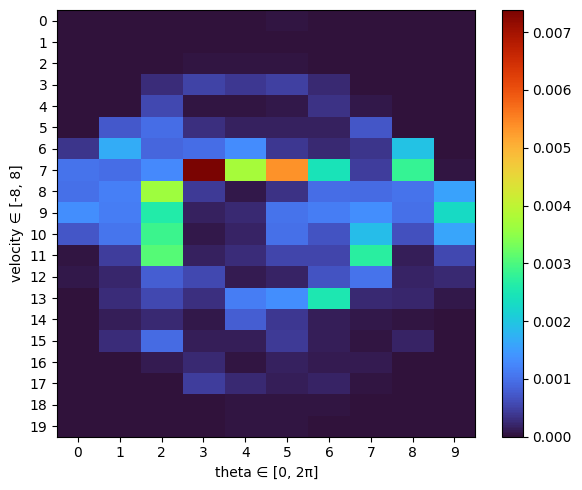

Pendulum-v1


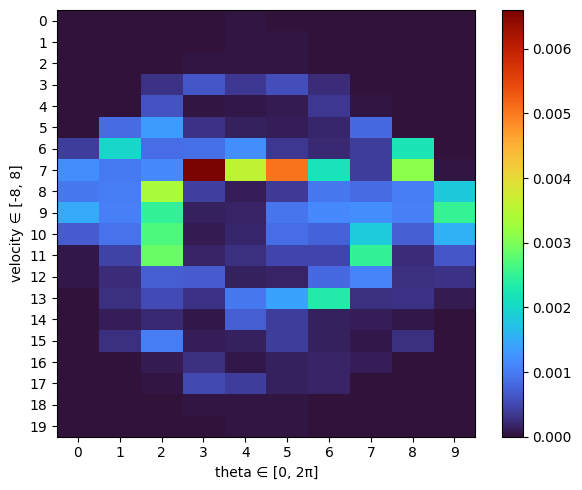

Pendulum-v1


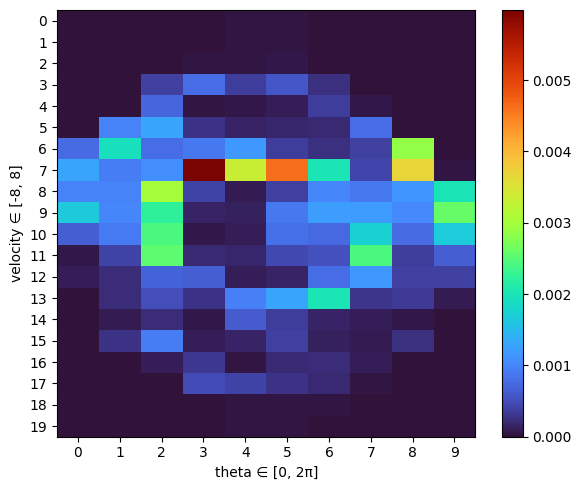

Pendulum-v1


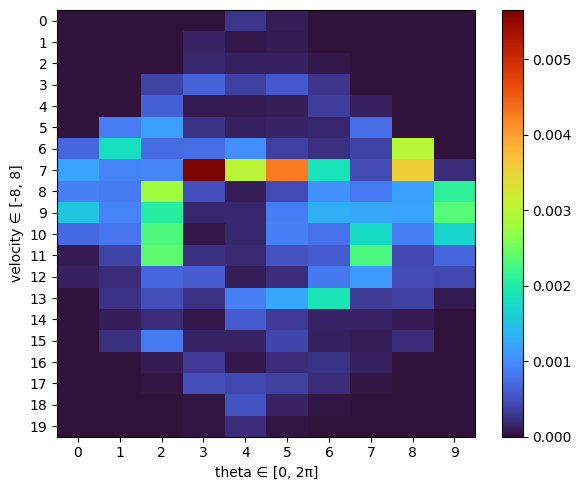

Pendulum-v1


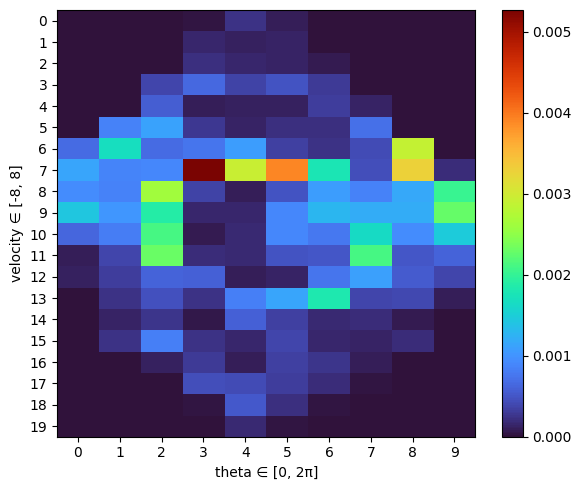

Pendulum-v1


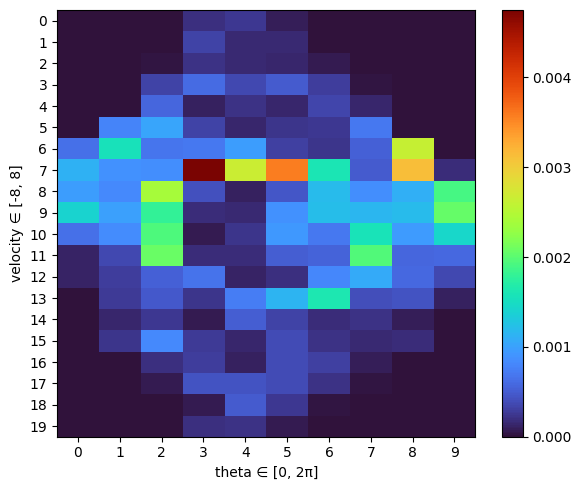

Pendulum-v1


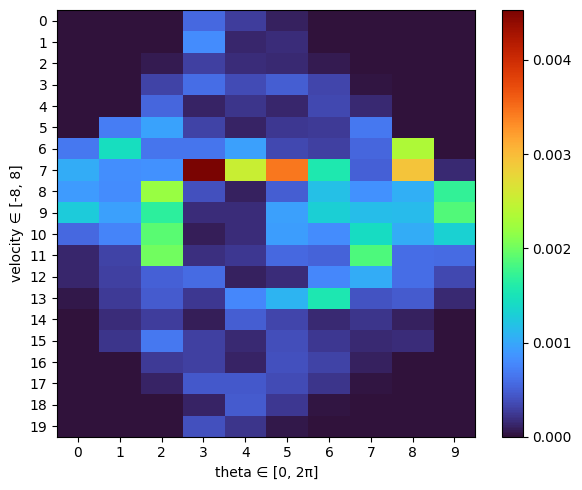

In [17]:
from plotting import plot_sa_heatmap
def plots_p_sa_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"], base_args["s_bins"], base_args["a_bins"]) 

    epochs=len(run)
    
    for i in range(epochs):

        transitions = run[i]["all_rollouts"]
        p_sa = p_sa_from_rollouts(transitions, sa_agg)

        plot_sa_heatmap(base_args["env_name"], p_sa, sa_agg)


from scipy.sparse.linalg import eigsh
def eig_sparse(SR, k=131):
    SR = (SR + SR.T) / 2.0
    eigenvalues, eigenvectors = eigsh(SR, sigma=None, k=k, which="LM")
    idx = np.argsort(-eigenvalues.real)
    eigenvalues = np.real_if_close(eigenvalues, tol=1e5)[idx]
    eigenvectors = np.real_if_close(eigenvectors, tol=1e5)[:, idx]
    return eigenvectors, eigenvalues
    
def plots_sr_from_run(base_args, run):
    s_agg, sa_agg = get_aggregator(base_args["env_name"], base_args["s_bins"], base_args["a_bins"])
    epochs=len(run)
    for i in range(epochs):

        transitions = run[i]["all_rollouts"]
        print(type(transitions))
        SR = sa_sr_from_rollouts(transitions, sa_agg)
        SR = SR.toarray()
        p_sa = p_sa_from_rollouts(transitions, sa_agg)

        top_eig, eigv= eig_sparse(SR, 5)
        top_eig = top_eig[:, 0]
        plot_sa_heatmap(base_args["env_name"], sa_agg.unflatten_sa_table(top_eig), sa_agg)
        print(np.dot(top_eig.flatten(), p_sa.flatten()))
    
def plots_l1_rew_by_epoch(base_args, run):

    s_agg, sa_agg = get_aggregator(base_args["env_name"], base_args["s_bins"], base_args["a_bins"])
    epochs=len(run)
    for i in range(epochs):

        transitions = run[i]["all_rollouts"]
        p_sa = p_sa_from_rollouts(transitions, sa_agg)
        uniform_density_sa = np.ones(sa_agg.shape())
        l1_cov_reward = 1 / (base_args["l1_eps"] * uniform_density_sa + p_sa)
        plot_sa_heatmap(base_args["env_name"], l1_cov_reward, sa_agg)



        
        





run_e1 = read_pickle(os.path.join(EXP_DIR, "eigenoptions/part2_run.pkl"))
# plots_sr_from_run(base_args, run_e0)
# plots_l1_rew_by_epoch(base_args, run_e1)
plots_p_sa_from_run(base_args, run_e1)

Pendulum-v1


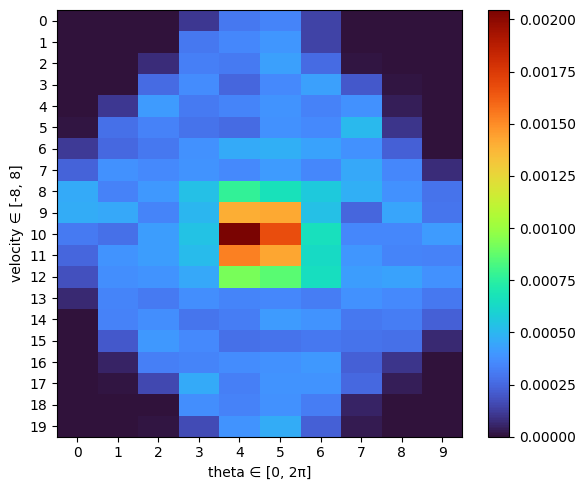

Pendulum-v1


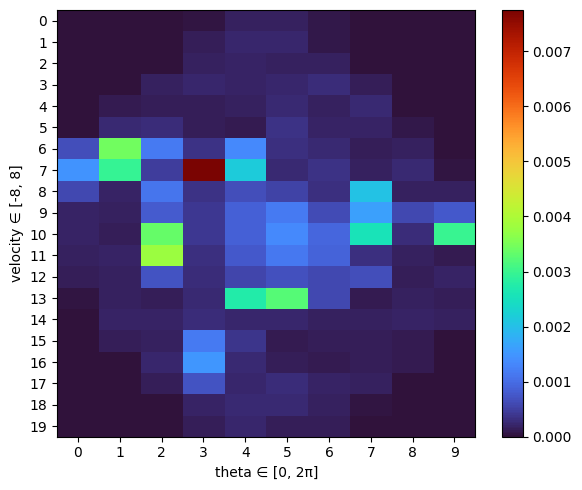

Pendulum-v1


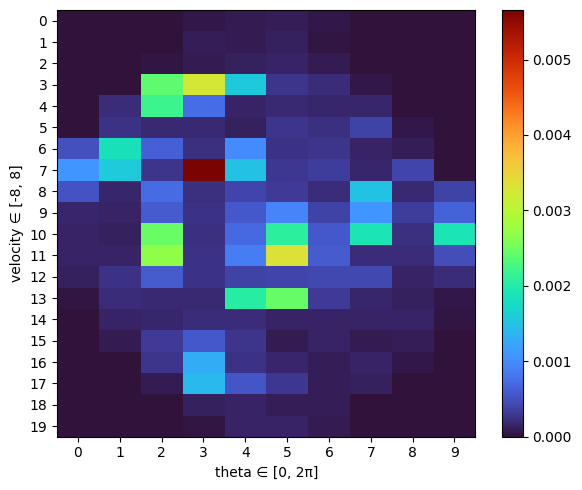

Pendulum-v1


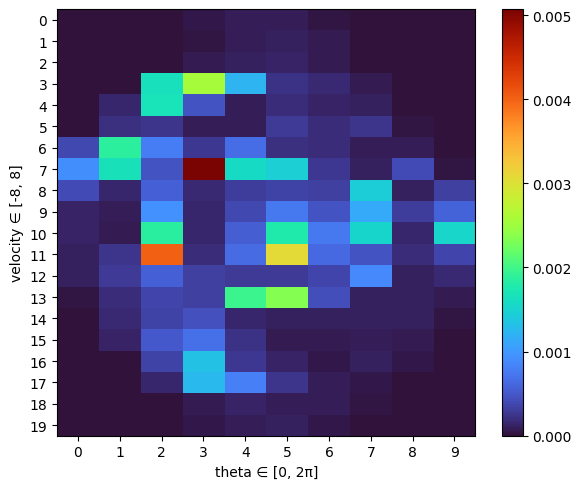

Pendulum-v1


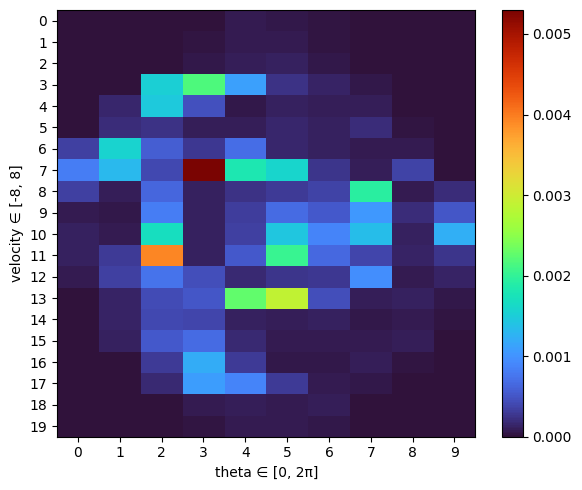

Pendulum-v1


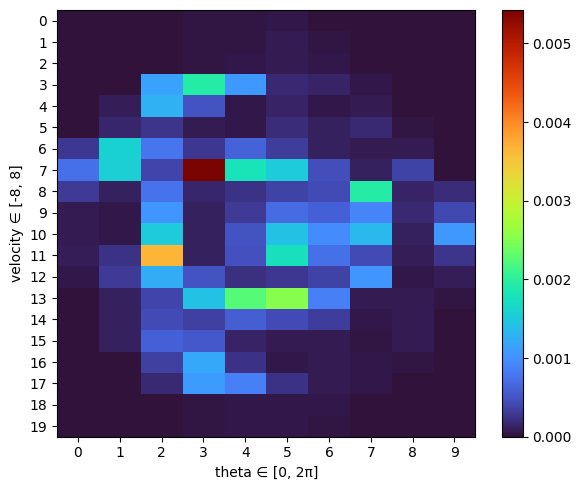

Pendulum-v1


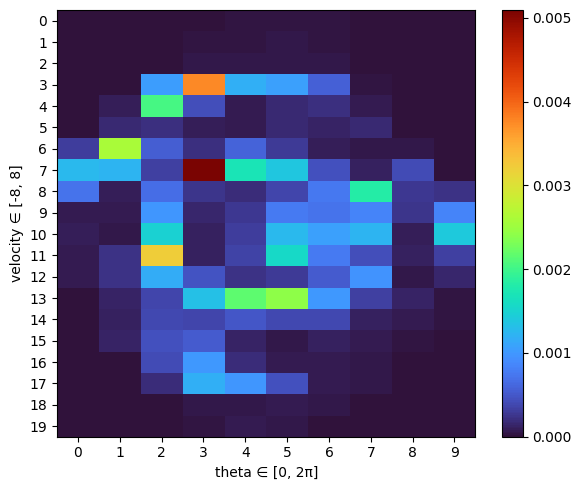

Pendulum-v1


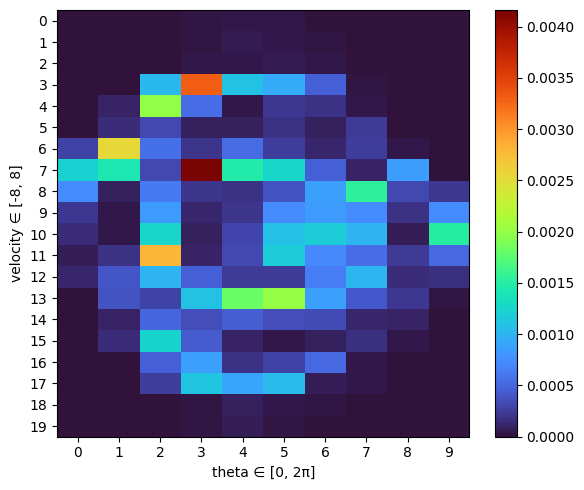

Pendulum-v1


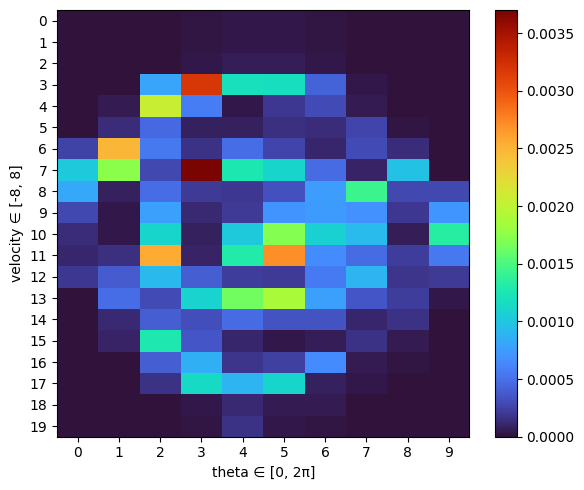

Pendulum-v1


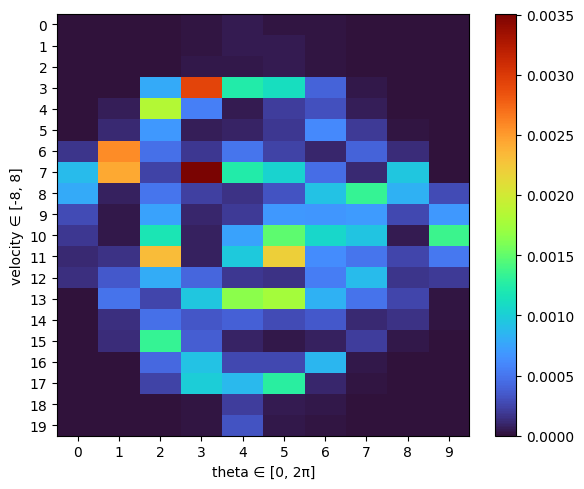

Pendulum-v1


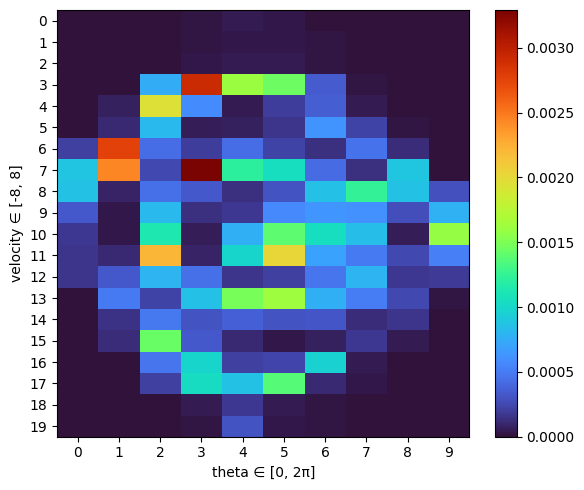

Pendulum-v1


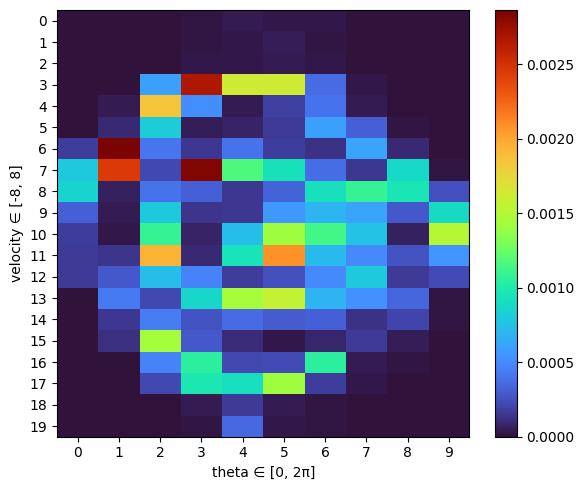

Pendulum-v1


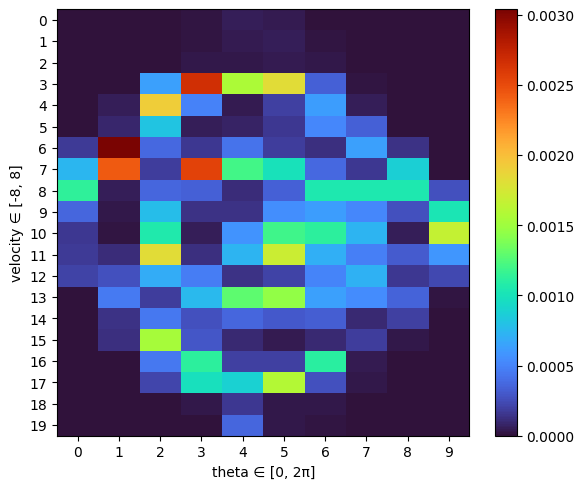

Pendulum-v1


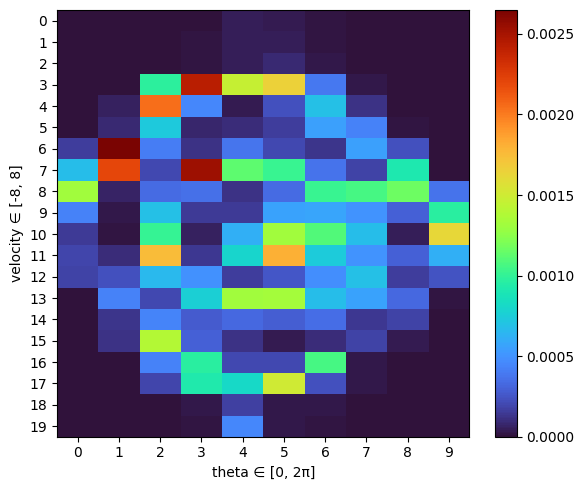

Pendulum-v1


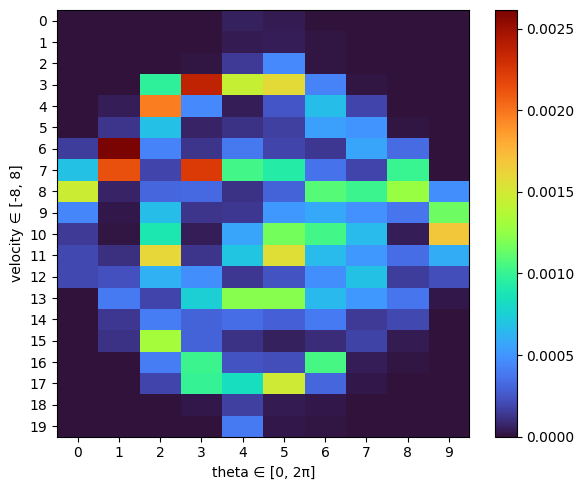

Pendulum-v1


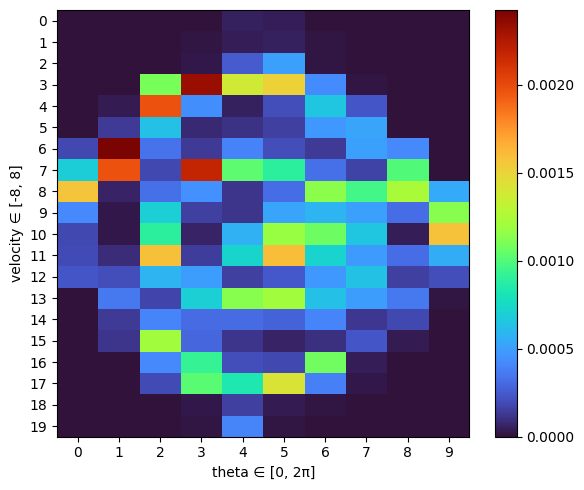

In [4]:
plots_p_sa_from_run(base_args, run_e0)

In [ ]:
l1_maxent = read_pickle(os.path.join(EXP_DIR, "maxent/all_l1_covs.pkl"))
l1_random = read_pickle(os.path.join(EXP_DIR, "random/all_l1_covs.pkl"))
l1_eig = read_pickle(os.path.join(EXP_DIR, "eigenoptions/all_l1_covs.pkl"))
l1_cov = read_pickle(os.path.join(EXP_DIR, "codex/all_l1_covs.pkl"))


